In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
from prophet import Prophet
import shap

shap.initjs()

C:\Users\Kevin\miniconda3\envs\py311\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\Kevin\miniconda3\envs\py311\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\Kevin\miniconda3\envs\py311\Lib\site-packages\shap\utils\_clustering.py:62: NumbaDe

In [19]:
path = Path.home() / 'OneDrive - Seagroup/mkt/mkt_mix'
df = pd.read_csv(path / 'ad_fb.csv', parse_dates=['DATE'])
print(df.shape)

(208, 12)


In [20]:
holidays = pd.read_csv(path / 'holiday.csv', parse_dates=["ds"])

holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [21]:
prophet_data = df.rename(columns = {'revenue': 'y', 'DATE': 'ds'})
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846,0,1
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000,0,1
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000,0,1
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000,0,1
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.0,60433,153723.666667,0.000000e+00,152840.323412,112100,7612762,0.000000,na,28157.000000,0,1
204,2019-10-21,2.182825e+06,154917.6,0,0.000000,5.688196e+07,103680.047821,103700,6701667,133624.575524,na,10644.000000,0,1
205,2019-10-28,2.377707e+06,21982.5,14094,17476.000000,0.000000e+00,138387.704138,114700,7688920,0.000000,na,9597.000000,0,1
206,2019-11-04,2.732825e+06,22453.0,0,24051.333333,0.000000e+00,151707.990462,134100,8815710,0.000000,na,90189.000000,0,1


In [22]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name='events_event2')
prophet.add_regressor(name='events_na')

In [23]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

10:01:05 - cmdstanpy - INFO - Chain [1] start processing
10:01:05 - cmdstanpy - INFO - Chain [1] done processing


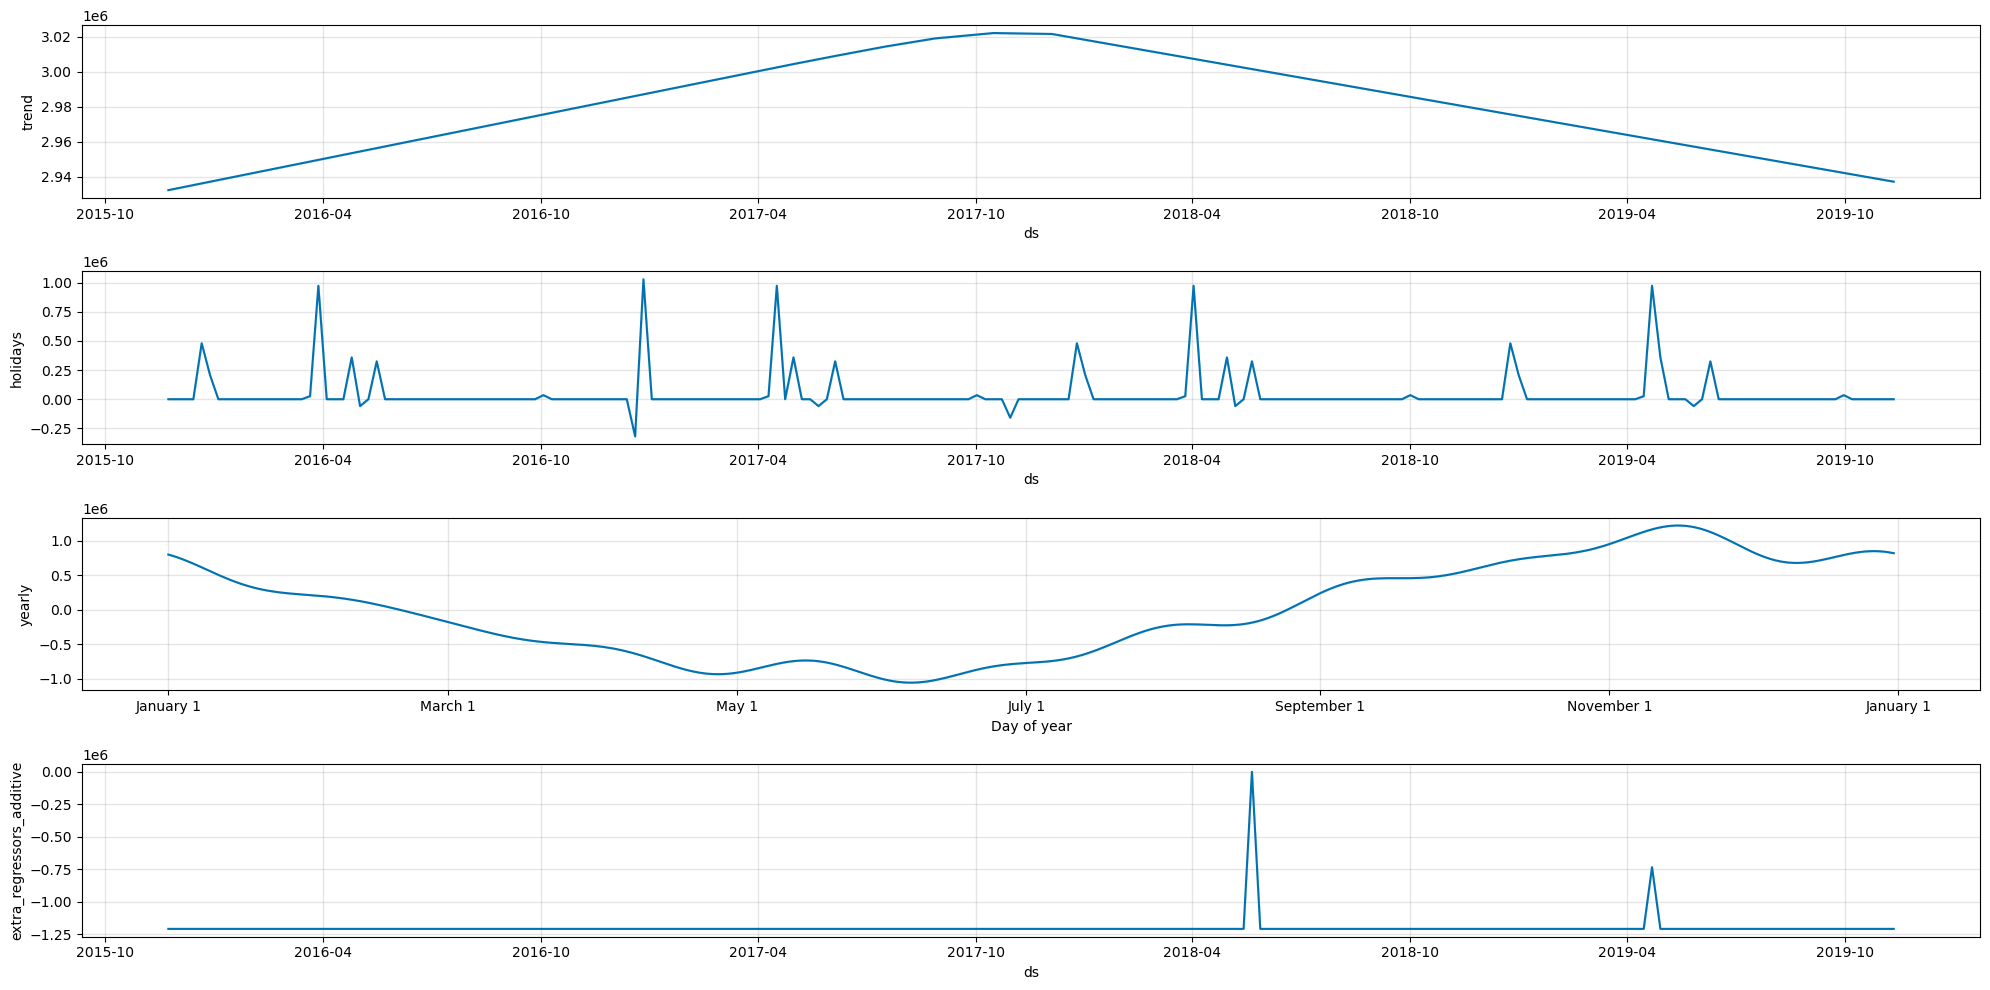

In [24]:
plot = prophet.plot_components(prophet_predict, figsize=(20, 10))

In [25]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = df.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

In [26]:
START_ANALYSIS_INDEX = 52
END_ANALYSIS_INDEX = 144

target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
features = ["trend", "season", "holiday", "competitor_sales_B", "events"] + media_channels + organic_channels

In [27]:
from functools import partial
import optuna as opt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score


def rssd(effect_share, spend_share):
    """RSSD decomposition

    Decomposition distance (root-sum-square distance, a major innovation of Robyn)
    eliminates the majority of "bad models"
    (larger prediction error and/or unrealistic media effect like the smallest channel getting the most effect

    Args:
        effect_share ([type]): percentage of effect share
        spend_share ([type]): percentage of spend share

    Returns:
        [type]: [description]
    """
    return np.sqrt(np.sum((effect_share - spend_share) ** 2))


def calculate_spend_effect_share(df_shap_values: pd.DataFrame, media_channels, df_original: pd.DataFrame):
    """
    Args:
        df_shap_values: data frame of shap values
        media_channels: list of media channel names
        df_original: non transformed original data
    Returns:
        [pd.DataFrame]: data frame with spend effect shares
    """
    responses = pd.DataFrame(df_shap_values[media_channels].abs().sum(axis = 0), columns = ["effect_share"])
    response_percentages = responses / responses.sum()

    spends_percentages = pd.DataFrame(df_original[media_channels].sum(axis = 0) / df_original[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])

    spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
    spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})

    return spend_effect_share


class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]

        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha* x_decayed[xi - 1]
        return x_decayed


def optuna_trial(trial,
                 data:pd.DataFrame,
                 target,
                 features,
                 adstock_features,
                 adstock_features_params,
                 media_features,
                 tscv,
                 is_multiobjective = False):

    data_temp = data.copy()
    adstock_alphas = {}

    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_uniform(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha

        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_temp[feature] = temp_adstock


    #Random Forest parameters
    n_estimators = trial.suggest_int("n_estimators", 5, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    max_depth = trial.suggest_int("max_depth", 4,7)
    ccp_alpha = trial.suggest_uniform("ccp_alpha", 0, 0.3)
    bootstrap = trial.suggest_categorical("bootstrap", [False, True])
    criterion = trial.suggest_categorical("criterion", ["squared_error"])  #"absolute_error"

    scores = []

    rssds = []
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]

        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]

        #apply Random Forest
        params = {"n_estimators": n_estimators,
                   "min_samples_leaf":min_samples_leaf,
                   "min_samples_split" : min_samples_split,
                   "max_depth" : max_depth,
                   "ccp_alpha" : ccp_alpha,
                   "bootstrap" : bootstrap,
                   "criterion" : criterion
                 }

        rf = RandomForestRegressor(random_state=0, **params)
        rf.fit(x_train, y_train)
        prediction = rf.predict(x_test)

        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)

        if is_multiobjective:

            #set_trace()
            #calculate spend effect share -> rssd
            # create explainer model by passing trained model to shap
            explainer = shap.TreeExplainer(rf)

            # get Shap values
            shap_values_train = explainer.shap_values(x_train)

            df_shap_values = pd.DataFrame(shap_values_train, columns=features)

            spend_effect_share = calculate_spend_effect_share(df_shap_values = df_shap_values, media_channels = media_features, df_original = data.iloc[train_index])

            decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
            rssds.append(decomp_rssd)

    trial.set_user_attr("scores", scores)

    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)

    if is_multiobjective == False:
        return np.mean(scores)


    trial.set_user_attr("rssds", rssds)

    #multiobjective
    return np.mean(scores), np.mean(rssds)


def optuna_optimize(trials,
                    data: pd.DataFrame,
                    target,
                    features,
                    adstock_features,
                    adstock_features_params,
                    media_features,
                    tscv,
                    is_multiobjective,
                    seed = 42):
    print(f"data size: {len(data)}")
    print(f"media features: {media_features}")
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")
    print(f"is_multiobjective: {is_multiobjective}")
    opt.logging.set_verbosity(opt.logging.WARNING)

    if is_multiobjective == False:
        study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))
    else:
        study_mmm = opt.create_study(directions=["minimize", "minimize"], sampler=opt.samplers.NSGAIISampler(seed=seed))

    optimization_function = partial(optuna_trial,
                                    data = data,
                                    target = target,
                                    features = features,
                                    adstock_features = adstock_features,
                                    adstock_features_params = adstock_features_params,
                                    media_features = media_features,
                                    tscv = tscv,
                                    is_multiobjective = is_multiobjective)


    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)

    return study_mmm

In [28]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3, test_size = 20)

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.0, 0.4)
adstock_features_params["search_S_adstock"] = (0.0, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

OPTUNA_TRIALS = 2000
experiment = optuna_optimize(trials = OPTUNA_TRIALS,
                             data = final_data,
                             target = target,
                             features = features,
                             adstock_features = media_channels + organic_channels,
                             adstock_features_params = adstock_features_params,
                             media_features=media_channels,
                             tscv = tscv,
                             is_multiobjective=False)

data size: 208
media features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
is_multiobjective: False


  0%|          | 0/2000 [00:00<?, ?it/s]

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.